The goal of this file is to run the following estimation experiments
* Output prediction accuracy as a function of ROM dimension (open- and closed-loop prediction)
* Full-order state prediction accuracy as a function of ROM dimension (open- and closed-loop prediction)

This notebook will also generate the following figures: 
* For a ROM dimension where all ROMs are decently predictive
    1. Output estimation trajectories for open and closed loop estimators on trajectories from the training and test set
    2. avg and std estimation error at that dimension
* Output estimation errors as a function of ROM dimension (subplot for open loop and for closed loop)


In [24]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.utils.extmath import randomized_svd
 
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from dotenv import dotenv_values 
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
import scipy.io
from scipy.signal import cont2discrete
import pyvista as pv
import h5py
import mat73
import dask.array as da
from dask.distributed import Client, LocalCluster
import opinf
config = dotenv_values(".env")
from util import *


In [25]:
####### Set up dask cluster #######
# Setup Dask client
# cluster = LocalCluster() # Launches a scheduler and workers locally
# client = Client(cluster) # Connect to distributed cluster and override default
client = Client('tcp://127.0.0.1:8786')
client.cluster

####### # Set up hyperparameters for all ROMs  #######
n_timesteps = 2000 # Number of timesteps to pull from each episode
dt = 0.001
n_train = 3 # Number of training episodes
n_test = 7 # Number of testing episodes
ns_ROM = np.arange(2,202,2) # Dimensions of ROM state space


In [26]:
####### Set up filepaths #######
# Setup filepaths for reading data 
filepath = config["currentDirectory"] + "data/archivedDataSets/FullAssembly_Constrained_FullSetForRAL_goodMatParams/"
romDir = config["currentDirectory"] + "data/archivedDataSets/FullAssembly_Constrained_FullSetForRAL_goodMatParams/ROMs/"

In [27]:
####### Load in data #######
# Read in all training data 
data = h5py.File(filepath+ "fullDataSet.hdf5", 'r')
X_fom = da.from_array(data["stateData"], chunks=(4096, 4096,1))
U_fom = da.from_array(data["inputData"], chunks=(4096, 4096,1))
U_fom = U_fom[:,0:n_timesteps,:].compute()
Y_fom = da.from_array(data["reducedCenterlineData"], chunks=(4096, 4096,1))
x0 = data["stateData"][:,0,0]
y0 = data["reducedCenterlineData"][:,0,0]
Y_fom = Y_fom[:,0:n_timesteps,:] - y0[:,None,None]
Y_fom = Y_fom.compute()


n = X_fom.shape[0]
l = U_fom.shape[0]
m = Y_fom.shape[0]


In [28]:
# Initialize arrays for storing relative estimation errors 
num_ROMs = len(ns_ROM)
rel_errors_era_ol = np.zeros((num_ROMs, n_test))
rel_errors_dmdc_ol = np.zeros((num_ROMs, n_test))

In [31]:
# iterate over all ROM dimensions
for i_romDim in range(num_ROMs):
    print("Running open loop simulation for ROM dimension: " + str(ns_ROM[i_romDim]))
    # Load in ROM models
    era_file = romDir + "eraSystemMatrices_" + str(ns_ROM[i_romDim])+"dim_" +str(n_train)+"train" +".npz"
    dmd_file = romDir + "dmdcSystemMatrices_" + str(ns_ROM[i_romDim])+"dim_" +"7train" + ".npz"
    eraData = np.load(era_file)
    dmdcData = np.load(dmd_file)
    A_era = eraData["A_era"]
    B_era = eraData["B_era"]
    C_era = eraData["C_era"]
    D_era = eraData["D_era"]
    x0_era = eraData["x0"]
    y0_era = eraData["y0"]
    A_dmdc = dmdcData["A_dmdc"]
    B_dmdc = dmdcData["B_dmdc"]
    C_dmdc = dmdcData["C_dmdc"]
    x0_dmdc = dmdcData["x0"]
    y0_dmdc = dmdcData["y0"]
    basis_dmdc = dmdcData["basis_dmdc"]
    # Initialize array for holding output estimates over time
    Y_era_ol = np.zeros((m, n_timesteps, n_test))
    Y_dmdc_ol = np.zeros((m, n_timesteps, n_test))
    # Initialize arrays for holding state estimates
    X_era_ol = np.zeros((ns_ROM[i_romDim], n_timesteps, n_test))
    X_dmdc_ol = np.zeros((ns_ROM[i_romDim], n_timesteps, n_test))
    # Iterate over all trials, running open loop simulations
    for k in range(n_test):
        Y_era_ol[:,0,k] = C_era @ X_era_ol[:,0,k] + D_era @ U_fom[:,0,k]
        # Iterate over timesteps
        for i in range(n_timesteps-1):
            # Compute open loop state estimate
            X_era_ol[:,i+1,k] = A_era @ X_era_ol[:,i,k] + B_era @ U_fom[:,i,k]
            X_dmdc_ol[:,i+1,k] = A_dmdc @ X_dmdc_ol[:,i,k] + B_dmdc @ U_fom[:,i,k]

            # Compute open loop output estimate
            Y_era_ol[:,i+1,k] = C_era @ X_era_ol[:,i+1,k] + D_era @ U_fom[:,i+1,k]
            Y_dmdc_ol[:,i+1,k] = C_dmdc @ X_dmdc_ol[:,i+1,k] 
    # print("Computing relative errors...")
    for i in range(n_test):
        # print("Test trial: " + str(i))
        rel_errors_era_ol[i_romDim,i] = np.linalg.norm(Y_fom[:,:,i+n_train]-Y_era_ol[:,:,i],)/np.linalg.norm(Y_fom[:,:,i+n_train])
        rel_errors_dmdc_ol[i_romDim,i] = np.linalg.norm(Y_fom[:,:,i+n_train]-Y_dmdc_ol[:,:,i])/np.linalg.norm(Y_fom[:,:,i+n_train])
            
        

Running open loop simulation for ROM dimension: 2
Running open loop simulation for ROM dimension: 4
Running open loop simulation for ROM dimension: 6
Running open loop simulation for ROM dimension: 8
Running open loop simulation for ROM dimension: 10
Running open loop simulation for ROM dimension: 12
Running open loop simulation for ROM dimension: 14
Running open loop simulation for ROM dimension: 16
Running open loop simulation for ROM dimension: 18
Running open loop simulation for ROM dimension: 20
Running open loop simulation for ROM dimension: 22
Running open loop simulation for ROM dimension: 24
Running open loop simulation for ROM dimension: 26
Running open loop simulation for ROM dimension: 28
Running open loop simulation for ROM dimension: 30
Running open loop simulation for ROM dimension: 32
Running open loop simulation for ROM dimension: 34
Running open loop simulation for ROM dimension: 36
Running open loop simulation for ROM dimension: 38
Running open loop simulation for RO

In [32]:
# Compute average and standard deviation of relative errors
avg_rel_errors_era_ol = np.mean(rel_errors_era_ol, axis=1)
std_rel_errors_era_ol = np.std(rel_errors_era_ol, axis=1)
avg_rel_errors_dmdc_ol = np.mean(rel_errors_dmdc_ol, axis=1)
std_rel_errors_dmdc_ol = np.std(rel_errors_dmdc_ol, axis=1)


In [33]:
avg_rel_errors_era_ol


array([0.98196522, 1.05179411, 1.04373842, 1.0473041 , 1.04790736,
       1.03737222, 1.06545445, 1.06410214, 1.06681952, 1.07083653,
       1.05734956, 1.06056253, 1.06480483, 1.07593459, 1.08061201,
       1.07326151, 1.07345136, 1.07893794, 1.08723187, 1.09275111,
       1.08938579, 1.07633196, 1.08477513, 1.08542946, 1.08317233,
       1.0831203 , 1.08269073, 1.08022875, 1.08431995, 1.08486438,
       1.08492088, 1.08603918, 1.08258048, 1.08325978, 1.08507082,
       1.08516587, 1.08274777, 1.08447708, 1.08472536, 1.08658577,
       1.08467828, 1.08515199, 1.08504255, 1.08634792, 1.08409109,
       1.08368898, 1.08733169, 1.08665167, 1.0856103 , 1.08856313,
       1.08768149, 1.08456458, 1.08916427, 1.08756874, 1.0881965 ,
       1.08871914, 1.08934011, 1.0870299 , 1.086618  , 1.08836268,
       1.08793999, 1.08917859, 1.08845911, 1.08823472, 1.08840468,
       1.08894595, 1.08832074, 1.08896997, 1.08923075, 1.08956414,
       1.0893793 , 1.08961366, 1.08953288, 1.08989223, 1.09003

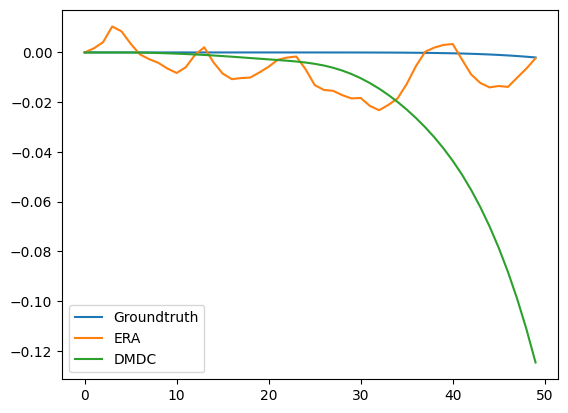

In [39]:
# Plot first output for each method on the first trial
steps = 50
episode = 0
output = 1
plt.figure()
plt.plot(Y_fom[output,:steps,episode], label="Groundtruth")
plt.plot(Y_era_ol[output,:steps,episode], label="ERA")
plt.plot(Y_dmdc_ol[output,:steps,episode], label="DMDC")
plt.legend()
plt.show()


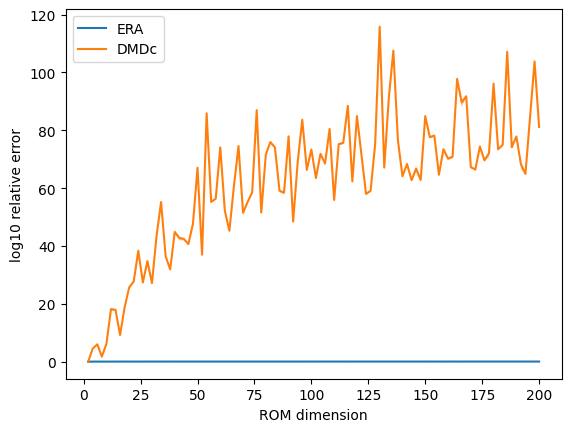

In [35]:
# Plot log of relative erros for each method over ROM dimension with grey regions indicating standard deviation
plt.figure()
plt.plot(ns_ROM, np.log10(avg_rel_errors_era_ol), label="ERA")
plt.fill_between(ns_ROM, np.log10(avg_rel_errors_era_ol-std_rel_errors_era_ol), np.log10(avg_rel_errors_era_ol+std_rel_errors_era_ol), alpha=0.5)
plt.plot(ns_ROM, np.log10(avg_rel_errors_dmdc_ol), label="DMDc")
plt.fill_between(ns_ROM, np.log10(avg_rel_errors_dmdc_ol-std_rel_errors_dmdc_ol), np.log10(avg_rel_errors_dmdc_ol+std_rel_errors_dmdc_ol), alpha=0.5)
plt.xlabel("ROM dimension")
plt.ylabel("log10 relative error")
plt.legend()
plt.show()


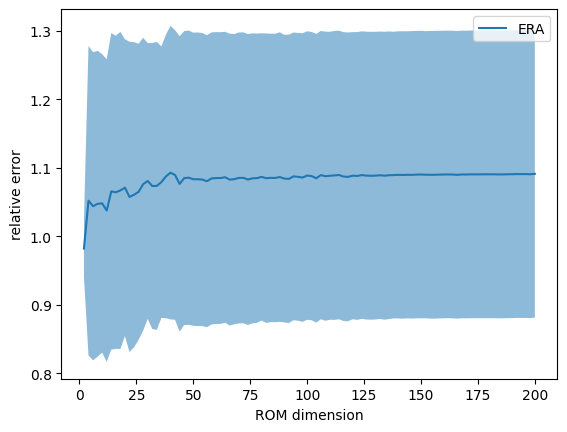

In [36]:
# Plot relative erros for each method over ROM dimension with grey regions indicating standard deviation
plt.figure()
plt.plot(ns_ROM, avg_rel_errors_era_ol, label="ERA")
plt.fill_between(ns_ROM, avg_rel_errors_era_ol-std_rel_errors_era_ol, avg_rel_errors_era_ol+std_rel_errors_era_ol, alpha=0.5)
# plt.plot(ns_ROM, avg_rel_errors_dmdc_ol, label="DMDc")
# plt.fill_between(ns_ROM, avg_rel_errors_dmdc_ol-std_rel_errors_dmdc_ol, avg_rel_errors_dmdc_ol+std_rel_errors_dmdc_ol, alpha=0.5)
plt.xlabel("ROM dimension")
plt.ylabel("relative error")
plt.legend()
plt.show()